In [1]:
import os
import time
import json
import random
import pandas as pd
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
from qdrant_client import QdrantClient, models

In [2]:
import os
os.environ["GROQ_API_KEY"] = "gsk_xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

In [3]:
from groq import Groq

client = Groq()

In [4]:
model_name = 'multi-qa-MiniLM-L6-cos-v1'
embedding_model = SentenceTransformer(model_name)

In [5]:
qd_client = QdrantClient(
    url="http://localhost:6333",
    timeout=60  # seconds (1 minutes)
)

collection_name = "medical-faq"


In [71]:
def vector_search(qdrant_client, embedding_model, query, qtype=None,limit=2):
    """Performs semantic vector search from Qdrant."""
    query_vector = embedding_model.encode(query).tolist()

    query_filter = None
    if qtype:
        query_filter = models.Filter(
            must=[models.FieldCondition(key="qtype", match=models.MatchValue(value=qtype))]
        )

    results = qdrant_client.query_points(
        collection_name=collection_name,
        query=query_vector,
        query_filter=query_filter,
        limit=limit,
        with_payload=True
    )

    return [p.payload for p in results.points]


In [7]:
def build_prompt(query, search_results):

    prompt_template = """
You are a professional medical assistant.
Answer the QUESTION using only the CONTEXT provided from verified medical sources.
If the answer is not available in the CONTEXT, say "I'm not sure based on the available information."

QUESTION: {question}

CONTEXT:
{context}
""".strip()
    
    context = ""
    
    for doc in search_results:
        context = context + f"question: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [8]:
def llm(prompt, model='openai/gpt-oss-20b'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [9]:
def rag(query: dict, qdrant_client, embedding_model, gpt_model='openai/gpt-oss-20b'):
    search_results = vector_search(qdrant_client, embedding_model, query['question'], query['qtype'])
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, gpt_model)
    return answer

In [10]:
with open('./../dataset/medical_qa_documents_with_id.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

df_ground_truth = pd.read_csv('./../dataset/search_ground-truth-data.csv')
# df_ground_truth = df_ground_truth[df_ground_truth.qtype == 'information']
ground_truth = df_ground_truth.to_dict(orient='records')

In [11]:
documents = docs_raw[0]["documents"]  # get the list of Q&A documents

In [12]:
doc_idx = {d['id']: d for d in documents}

### Evaluating openai/gpt-oss-20b with Groq Api

In [61]:
gpt_model = 'openai/gpt-oss-20b'
results_dict_20b = {}

In [13]:
# --- Sample 30 random entries ---
gt_sampled_data = random.sample(ground_truth, 50)

In [14]:
gt_sampled_data

[{'question': 'What medical history questions will my doctor ask to assess my risk for thrombotic thrombocytopenic purpura?',
  'qtype': 'exams and tests',
  'document': '53a314dd'},
 {'question': 'Can Bartter syndrome cause kidney complications like nephrocalcinosis or bone problems?',
  'qtype': 'symptoms',
  'document': 'e3e8adf5'},
 {'question': 'Can radiation therapy be used as a primary treatment for hemangioendothelioma?',
  'qtype': 'treatment',
  'document': 'd75db300'},
 {'question': 'Do newborns or children have a higher chance of inherited thrombotic thrombocytopenic purpura?',
  'qtype': 'susceptibility',
  'document': '87a80996'},
 {'question': 'Which areas of the mouth and throat are most at risk for squamous cell carcinoma?',
  'qtype': 'information',
  'document': '651a377e'},
 {'question': 'Is delayed puberty a typical symptom of Kallmann syndrome 6?',
  'qtype': 'symptoms',
  'document': 'a7589824'},
 {'question': 'What vision problems are commonly seen in patients w

In [15]:
for i, rec in enumerate(tqdm(gt_sampled_data)):
    if i in results_dict:
        continue
    try:

        answer_llm = rag(rec, qd_client, embedding_model, gpt_model)
        doc_id = rec['document']
        original_doc = doc_idx[doc_id]
        answer_orig = original_doc['answer']

        emb_orig = embedding_model.encode(answer_orig)
        emb_llm = embedding_model.encode(answer_llm)
        similarity = cosine_similarity([emb_orig], [emb_llm])[0][0]

        results_dict_20b[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_orig,
            'document': doc_id,
            'question': rec['question'],
            'qtype': rec['qtype'],
            'Cosine Similarity': similarity
        }
    except Exception as e:
        print(f"Error at index {i}: {e}")
    time.sleep(10) # used because of free trial token limitationin minutes

  2%|▉                                           | 1/50 [00:13<10:43, 13.14s/it]

Error at index 1: Connection error.


 10%|████▍                                       | 5/50 [01:07<09:55, 13.24s/it]

Error at index 5: Connection error.


 72%|██████████████████████████████▉            | 36/50 [09:29<03:01, 12.99s/it]

Error at index 36: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-20b` in organization `org_01k606fwfbfy0v3979np47tb81` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 8798, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


100%|███████████████████████████████████████████| 50/50 [13:12<00:00, 15.85s/it]


In [21]:
df_20b = pd.DataFrame(results_dict_20b).T
df_20b.to_csv("./../dataset/rag_eval_results_gpt-oss-20b.csv", index=False)
print("Results saved to rag_eval_results_gpt-oss-20b.csv")

Results saved to rag_eval_results_gpt-oss-20b.csv


In [48]:
mean_score = float(df_20b['Cosine Similarity'].mean())
print(f"Average Cosine Similarity: {mean_score:.3f}")

Average Cosine Similarity: 0.613


In [84]:
df_20b

,answer_llm,answer_orig,document,question,qtype,Cosine Similarity
0,"Based on the medical information provided, a d...",Your doctor will diagnosis thrombotic thromboc...,53a314dd,What medical history questions will my doctor ...,exams and tests,0.642945
1,"Yes. According to the published case series, ...",How might hemangioendothelioma be treated? Tre...,d75db300,Can radiation therapy be used as a primary tre...,treatment,0.789150
2,"Yes. According to the provided information, in...",Thrombotic thrombocytopenic purpura (TTP) is a...,87a80996,Do newborns or children have a higher chance o...,susceptibility,0.857198
3,Squamous cell carcinoma (SCC) most commonly ar...,Squamous cell carcinoma is a cancer that arise...,651a377e,Which areas of the mouth and throat are most a...,information,0.796915
4,Patients with osteoporosis‑pseudoglioma syndro...,"Spondyloepimetaphyseal dysplasia, Strudwick ty...",2ecd7c14,What vision problems are commonly seen in pati...,information,0.531258
5,Because the disorder is Bronchopulmonary Dyspl...,Autosomal recessive pseudohypoaldosteronism ty...,dca0c466,Why are respiratory infections more frequent i...,information,0.308115
6,Mutations in the **KRT5** or **KRT14** genes a...,The four major types of epidermolysis bullosa ...,08d7e53d,What impact do mutations in the KRT5 or KRT14 ...,genetic changes,0.734526
7,Hypotrichosis simplex can be inherited in two ...,Hypotrichosis simplex is a rare form of heredi...,eb86628a,How is hypotrichosis simplex inherited?,information,0.785520
8,**Short answer:** \nYes—many of the cancers d...,Squamous cell carcinoma is a cancer that arise...,651a377e,Can this type of cancer spread to my lungs or ...,information,0.640935
9,I'm not sure based on the available information.,Hearing loss can result from taking certain me...,b9c48750,Which medications are known to harm the inner ...,causes,-0.092635


### Evaluating openai/gpt-oss-120b with Groq Api

In [65]:
gpt_model = 'openai/gpt-oss-120b'
results_dict_120b = {}

In [66]:
for i, rec in enumerate(tqdm(gt_sampled_data)):
    if i in results_dict_120b:
        continue
    try:

        answer_llm = rag(rec, qd_client, embedding_model, gpt_model)
        doc_id = rec['document']
        original_doc = doc_idx[doc_id]
        answer_orig = original_doc['answer']

        emb_orig = embedding_model.encode(answer_orig)
        emb_llm = embedding_model.encode(answer_llm)
        similarity = cosine_similarity([emb_orig], [emb_llm])[0][0]

        results_dict_120b[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_orig,
            'document': doc_id,
            'question': rec['question'],
            'qtype': rec['qtype'],
            'Cosine Similarity': similarity
        }
    except Exception as e:
        print(f"Error at index {i}: {e}")
    time.sleep(10) # used because of free trial token limitationin minutes

 72%|██████████████████████████████▉            | 36/50 [13:13<04:10, 17.86s/it]

Error at index 36: Error code: 413 - {'error': {'message': 'Request too large for model `openai/gpt-oss-120b` in organization `org_01k606fwfbfy0v3979np47tb81` service tier `on_demand` on tokens per minute (TPM): Limit 8000, Requested 8798, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}


100%|███████████████████████████████████████████| 50/50 [18:08<00:00, 21.76s/it]


In [67]:
df_120b = pd.DataFrame(results_dict_120b).T
df_120b.to_csv("./../dataset/rag_eval_results_gpt-oss-120b.csv", index=False)
print("Results saved to rag_eval_results_gpt-oss-120b.csv")

Results saved to rag_eval_results_gpt-oss-120b.csv


In [69]:
mean_score = float(df_120b['Cosine Similarity'].mean())
print(f"Average Cosine Similarity: {mean_score:.3f}")

Average Cosine Similarity: 0.607


In [70]:
df_120b

,answer_llm,answer_orig,document,question,qtype,Cosine Similarity
0,Your doctor will ask about any factors that ca...,Your doctor will diagnosis thrombotic thromboc...,53a314dd,What medical history questions will my doctor ...,exams and tests,0.654972
1,"Yes. According to the provided information, th...",What are the signs and symptoms of Bartter syn...,e3e8adf5,Can Bartter syndrome cause kidney complication...,symptoms,0.586107
2,Yes. While surgical excision is the most commo...,How might hemangioendothelioma be treated? Tre...,d75db300,Can radiation therapy be used as a primary tre...,treatment,0.786532
3,"Based on the information provided, inherited t...",Thrombotic thrombocytopenic purpura (TTP) is a...,87a80996,Do newborns or children have a higher chance o...,susceptibility,0.896889
4,The sites in the mouth and throat that are mos...,Squamous cell carcinoma is a cancer that arise...,651a377e,Which areas of the mouth and throat are most a...,information,0.78836
5,Yes. In Kallmann syndrome 6 the listed hallmar...,What are the signs and symptoms of Kallmann sy...,a7589824,Is delayed puberty a typical symptom of Kallma...,symptoms,0.460289
6,Patients with osteoporosis‑pseudoglioma syndro...,"Spondyloepimetaphyseal dysplasia, Strudwick ty...",2ecd7c14,What vision problems are commonly seen in pati...,information,0.510115
7,Respiratory infections occur more often in chi...,Autosomal recessive pseudohypoaldosteronism ty...,dca0c466,Why are respiratory infections more frequent i...,information,0.082725
8,Mutations in KRT5 or KRT14 disrupt the normal ...,The four major types of epidermolysis bullosa ...,08d7e53d,What impact do mutations in the KRT5 or KRT14 ...,genetic changes,0.70808
9,Hypotrichosis simplex can be inherited in eith...,Hypotrichosis simplex is a rare form of heredi...,eb86628a,How is hypotrichosis simplex inherited?,information,0.777561


In [73]:
gpt_model = 'llama-3.3-70b-versatile'
results_dict_llama_70b = {}

In [74]:
for i, rec in enumerate(tqdm(gt_sampled_data)):
    if i in results_dict_llama_70b:
        continue
    try:

        answer_llm = rag(rec, qd_client, embedding_model, gpt_model)
        doc_id = rec['document']
        original_doc = doc_idx[doc_id]
        answer_orig = original_doc['answer']

        emb_orig = embedding_model.encode(answer_orig)
        emb_llm = embedding_model.encode(answer_llm)
        similarity = cosine_similarity([emb_orig], [emb_llm])[0][0]

        results_dict_llama_70b[i] = {
            'answer_llm': answer_llm,
            'answer_orig': answer_orig,
            'document': doc_id,
            'question': rec['question'],
            'qtype': rec['qtype'],
            'Cosine Similarity': similarity
        }
    except Exception as e:
        print(f"Error at index {i}: {e}")
    time.sleep(10) # used because of free trial token limitationin minutes

100%|███████████████████████████████████████████| 50/50 [15:12<00:00, 18.24s/it]


In [75]:
df_70b = pd.DataFrame(results_dict_llama_70b).T
df_70b.to_csv("./../dataset/rag_eval_results_llama-70.csv", index=False)
print("Results saved to rag_eval_results_llama-70.csv")

Results saved to rag_eval_results_llama-70.csv


In [76]:
mean_score = float(df_70b['Cosine Similarity'].mean())
print(f"Average Cosine Similarity: {mean_score:.3f}")

Average Cosine Similarity: 0.683


In [77]:
df_70b

,answer_llm,answer_orig,document,question,qtype,Cosine Similarity
0,To assess your risk for thrombotic thrombocyto...,Your doctor will diagnosis thrombotic thromboc...,53a314dd,What medical history questions will my doctor ...,exams and tests,0.655826
1,"Yes, Bartter syndrome can cause kidney complic...",What are the signs and symptoms of Bartter syn...,e3e8adf5,Can Bartter syndrome cause kidney complication...,symptoms,0.642835
2,"According to the provided context, radiation t...",How might hemangioendothelioma be treated? Tre...,d75db300,Can radiation therapy be used as a primary tre...,treatment,0.833265
3,Newborns and children have a higher chance of ...,Thrombotic thrombocytopenic purpura (TTP) is a...,87a80996,Do newborns or children have a higher chance o...,susceptibility,0.864994
4,The areas of the mouth and throat most at risk...,Squamous cell carcinoma is a cancer that arise...,651a377e,Which areas of the mouth and throat are most a...,information,0.78851
5,I'm not sure based on the available informatio...,What are the signs and symptoms of Kallmann sy...,a7589824,Is delayed puberty a typical symptom of Kallma...,symptoms,0.574134
6,Vision problems commonly seen in patients with...,"Spondyloepimetaphyseal dysplasia, Strudwick ty...",2ecd7c14,What vision problems are commonly seen in pati...,information,0.484153
7,I'm not sure based on the available informatio...,Autosomal recessive pseudohypoaldosteronism ty...,dca0c466,Why are respiratory infections more frequent i...,information,0.1939
8,I'm not sure based on the available informatio...,The four major types of epidermolysis bullosa ...,08d7e53d,What impact do mutations in the KRT5 or KRT14 ...,genetic changes,0.599138
9,Hypotrichosis simplex can be inherited either ...,Hypotrichosis simplex is a rare form of heredi...,eb86628a,How is hypotrichosis simplex inherited?,information,0.764298


In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_850580/3138566786.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_20b['Cosine Similarity'], label='oss-20b')
/tmp/ipykernel_850580/3138566786.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_120b['Cosine Similarity'], label='oss-120b')
/tmp/ipykernel_850580/3138566786

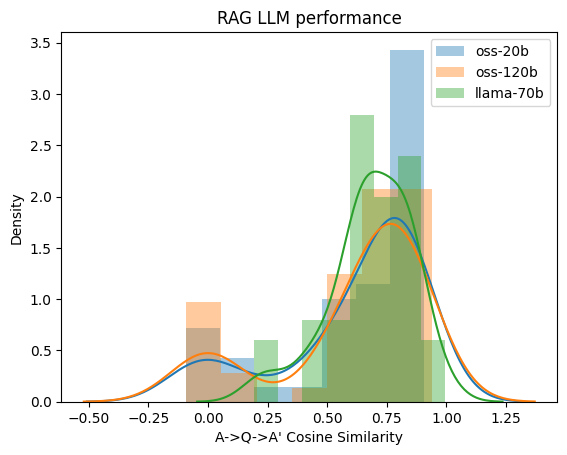

In [85]:
sns.distplot(df_20b['Cosine Similarity'], label='oss-20b')
sns.distplot(df_120b['Cosine Similarity'], label='oss-120b')
sns.distplot(df_70b['Cosine Similarity'], label='llama-70b')


plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [92]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

#### using prompt1_template

In [93]:
dict_70b = df_70b.to_dict(orient='records')

In [95]:
evaluations = []

for i, record in enumerate(tqdm(dict_70b)):
    try:
        prompt = prompt1_template.format(**record)
        evaluation = llm(prompt, model='openai/gpt-oss-20b')
        evaluations.append(evaluation)
    except Exception as e:
        print(f"Error at index {i}: {e}")
    time.sleep(10)

100%|███████████████████████████████████████████| 50/50 [11:38<00:00, 13.96s/it]


In [96]:
import json
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [97]:
df_evaluations = pd.DataFrame(json_evaluations)

In [98]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           32
PARTLY_RELEVANT     9
NON_RELEVANT        9
Name: count, dtype: int64

In [99]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
6,NON_RELEVANT,The generated answer discusses vision problems...
7,NON_RELEVANT,The generated answer does not draw upon or ref...
10,NON_RELEVANT,The generated answer discusses malignant mesot...
23,NON_RELEVANT,The generated response does not address the qu...
24,NON_RELEVANT,The generated answer neither addresses the sig...
27,NON_RELEVANT,The generated answer does not address the ques...
33,NON_RELEVANT,The generated answer incorrectly claims that t...
39,NON_RELEVANT,The generated answer discusses frontometaphyse...
42,NON_RELEVANT,The generated answer does not address whether ...


#### using prompt2_template

In [106]:
evaluations = []

for i, record in enumerate(tqdm(dict_70b)):
    try:
        prompt = prompt2_template.format(**record)
        evaluation = llm(prompt, model='openai/gpt-oss-20b')
        evaluations.append(evaluation)
    except Exception as e:
        print(f"Error at index {i}: {e}")
    time.sleep(10)

100%|███████████████████████████████████████████| 50/50 [10:54<00:00, 13.08s/it]


In [101]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [102]:
df_evaluations = pd.DataFrame(json_evaluations)

In [103]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           4
PARTLY_RELEVANT    1
NON_RELEVANT       1
Name: count, dtype: int64

In [104]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
4,NON_RELEVANT,The generated answer explicitly states that it...
